# Imports

In [1]:
from tqdm import tqdm
import numpy as np
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguegamefinder, playercareerstats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fetch NBA Player Data

In [2]:
def fetchPlayerData(playerName):
    player = players.find_players_by_full_name(playerName)

    if player:
        playerID = player[0]['id']
        careerStats = playercareerstats.PlayerCareerStats(player_id=playerID)
        careerStatsDF = careerStats.get_data_frames()[0]
        seasons = careerStatsDF['SEASON_ID'].unique().tolist()
    else:
        print(f"Player {playerName} not found")
        exit()

    for season in seasons:
        gameFinder = leaguegamefinder.LeagueGameFinder(player_id_nullable=playerID, season_nullable=season)
        desiredColumns = ['TEAM_NAME', 'GAME_DATE', 'MATCHUP','WL', 'PTS', 'REB', 'AST', 'STL', 'BLK']
        games = games = gameFinder.get_data_frames()[0][desiredColumns]

        gamesDict = games.to_dict(orient='records')

        # Store data in JSON file
        fileName = f"data/raw/{playerName} {season} regular season games.json"
        with open(fileName, 'w') as json_file:
            json.dump(gamesDict, json_file, indent=4)

        print(f"Game data stored in {fileName}")

playerNameInput = input("Enter player name:")
fetchPlayerData(playerName=playerNameInput)

Game data stored in data/raw/Anthony Edwards 2020-21 regular season games.json
Game data stored in data/raw/Anthony Edwards 2021-22 regular season games.json
Game data stored in data/raw/Anthony Edwards 2022-23 regular season games.json
Game data stored in data/raw/Anthony Edwards 2023-24 regular season games.json
Game data stored in data/raw/Anthony Edwards 2024-25 regular season games.json


# Preprocess Data

In [3]:
class JSONDataset(Dataset):
    def __init__(self, JSONFile, transform=None):
        with open(JSONFile, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if not self.data:
            raise IndexError("Dataset is empty or not loaded properly.")
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [4]:
def customTransform(sample):
    inputData = torch.tensor([
        sample['PTS'], 
        sample['REB'], 
        sample['AST'], 
        sample['STL'], 
        sample['BLK']
    ], dtype=torch.float32)
    
    target = inputData.clone()
    
    return inputData, target

In [5]:
def getJSONFilePaths(directory):
    JSONFilePaths = []
    for root, dir, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                relPath = os.path.join(root, file)
                JSONFilePaths.append(os.path.normpath(relPath))
    return JSONFilePaths

In [6]:
JSONFilePaths = getJSONFilePaths("./data/raw")
print("Relative JSON file paths:")
print(JSONFilePaths)

Relative JSON file paths:
['data\\raw\\Anthony Edwards 2020-21 regular season games.json', 'data\\raw\\Anthony Edwards 2021-22 regular season games.json', 'data\\raw\\Anthony Edwards 2022-23 regular season games.json', 'data\\raw\\Anthony Edwards 2023-24 regular season games.json', 'data\\raw\\Anthony Edwards 2024-25 regular season games.json']


In [7]:
trainDatasets = [JSONDataset(json_file, transform=customTransform) for json_file in JSONFilePaths[0:-2]]
trainLoaders = [DataLoader(dataset, batch_size=2, shuffle=True) for dataset in trainDatasets]

valDataset = JSONDataset(JSONFilePaths[-2], transform=customTransform)
valLoader = DataLoader(valDataset, batch_size=2, shuffle=False)

testDataset = JSONDataset(JSONFilePaths[-1], transform=customTransform)
testLoader = DataLoader(testDataset, batch_size=2, shuffle=False)

# Define LSTM Model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize=5, hiddenSize=128, outputSize=5, numLayers=1):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.numLayers= 1
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True)
        self.fc = nn.Linear(hiddenSize, outputSize)
    
    def forward(self, x):
        h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        return self.fc(out[:, -1, :])

model = LSTMModel().to(device)

# Training Loop

In [9]:
def testModel(loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

In [10]:
def trainModel(NUM_EPOCHS = 40, lr = 0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0)

    for epoch in range(NUM_EPOCHS):
        model.train()
        print(f'==> Epoch {epoch+1}')
        
        for loader in trainLoaders:
            for inputs, targets in tqdm(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = inputs.unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        valLoss = testModel(valLoader, model, criterion)
        print(f'Validation Loss: {valLoss:.3f}')

trainModel()

==> Epoch 1


100%|██████████| 46/46 [00:00<00:00, 581.91it/s]


Validation Loss: 60.979
==> Epoch 2


100%|██████████| 46/46 [00:00<00:00, 609.07it/s]


Validation Loss: 20.739
==> Epoch 3


100%|██████████| 46/46 [00:00<00:00, 596.00it/s]


Validation Loss: 10.716
==> Epoch 4


100%|██████████| 46/46 [00:00<00:00, 596.07it/s]


Validation Loss: 6.660
==> Epoch 5


100%|██████████| 46/46 [00:00<00:00, 600.60it/s]


Validation Loss: 4.393
==> Epoch 6


100%|██████████| 46/46 [00:00<00:00, 596.75it/s]


Validation Loss: 3.023
==> Epoch 7


100%|██████████| 46/46 [00:00<00:00, 595.75it/s]


Validation Loss: 2.147
==> Epoch 8


100%|██████████| 46/46 [00:00<00:00, 577.35it/s]


Validation Loss: 1.721
==> Epoch 9


100%|██████████| 46/46 [00:00<00:00, 568.44it/s]


Validation Loss: 1.529
==> Epoch 10


100%|██████████| 46/46 [00:00<00:00, 573.42it/s]


Validation Loss: 1.058
==> Epoch 11


100%|██████████| 46/46 [00:00<00:00, 580.45it/s]


Validation Loss: 0.838
==> Epoch 12


100%|██████████| 46/46 [00:00<00:00, 569.16it/s]


Validation Loss: 0.663
==> Epoch 13


100%|██████████| 46/46 [00:00<00:00, 592.87it/s]


Validation Loss: 0.608
==> Epoch 14


100%|██████████| 46/46 [00:00<00:00, 564.59it/s]


Validation Loss: 0.881
==> Epoch 15


100%|██████████| 46/46 [00:00<00:00, 555.28it/s]


Validation Loss: 0.452
==> Epoch 16


100%|██████████| 46/46 [00:00<00:00, 565.04it/s]


Validation Loss: 0.510
==> Epoch 17


100%|██████████| 46/46 [00:00<00:00, 574.62it/s]


Validation Loss: 0.365
==> Epoch 18


100%|██████████| 46/46 [00:00<00:00, 581.68it/s]


Validation Loss: 0.411
==> Epoch 19


100%|██████████| 46/46 [00:00<00:00, 575.43it/s]


Validation Loss: 0.517
==> Epoch 20


100%|██████████| 46/46 [00:00<00:00, 568.60it/s]


Validation Loss: 0.274
==> Epoch 21


100%|██████████| 46/46 [00:00<00:00, 558.38it/s]


Validation Loss: 0.467
==> Epoch 22


100%|██████████| 46/46 [00:00<00:00, 554.68it/s]


Validation Loss: 0.234
==> Epoch 23


100%|██████████| 46/46 [00:00<00:00, 565.04it/s]


Validation Loss: 0.226
==> Epoch 24


100%|██████████| 46/46 [00:00<00:00, 563.13it/s]


Validation Loss: 0.185
==> Epoch 25


100%|██████████| 46/46 [00:00<00:00, 550.02it/s]


Validation Loss: 0.353
==> Epoch 26


100%|██████████| 46/46 [00:00<00:00, 561.42it/s]


Validation Loss: 0.224
==> Epoch 27


100%|██████████| 46/46 [00:00<00:00, 547.54it/s]


Validation Loss: 0.159
==> Epoch 28


100%|██████████| 46/46 [00:00<00:00, 563.60it/s]


Validation Loss: 0.146
==> Epoch 29


100%|██████████| 46/46 [00:00<00:00, 559.57it/s]


Validation Loss: 0.164
==> Epoch 30


100%|██████████| 46/46 [00:00<00:00, 547.42it/s]


Validation Loss: 0.156
==> Epoch 31


100%|██████████| 46/46 [00:00<00:00, 521.33it/s]


Validation Loss: 0.152
==> Epoch 32


100%|██████████| 46/46 [00:00<00:00, 562.34it/s]


Validation Loss: 0.146
==> Epoch 33


100%|██████████| 46/46 [00:00<00:00, 566.33it/s]


Validation Loss: 0.124
==> Epoch 34


100%|██████████| 46/46 [00:00<00:00, 557.86it/s]


Validation Loss: 0.120
==> Epoch 35


100%|██████████| 46/46 [00:00<00:00, 567.17it/s]


Validation Loss: 0.162
==> Epoch 36


100%|██████████| 46/46 [00:00<00:00, 572.78it/s]


Validation Loss: 0.154
==> Epoch 37


100%|██████████| 46/46 [00:00<00:00, 557.96it/s]


Validation Loss: 0.105
==> Epoch 38


100%|██████████| 46/46 [00:00<00:00, 553.98it/s]


Validation Loss: 0.113
==> Epoch 39


100%|██████████| 46/46 [00:00<00:00, 569.42it/s]


Validation Loss: 0.102
==> Epoch 40


100%|██████████| 46/46 [00:00<00:00, 550.78it/s]


Validation Loss: 0.095


# Testing Metrics

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, targets in testLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1) 
        outputs = model(inputs)
        
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()
        
        true_labels.extend(targets_np)
        predictions.extend(outputs_np)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.1625121533870697
Mean Absolute Error (MAE): 0.20091025531291962
R-squared (R2): 0.9829096794128418


# Plot Predicted vs Actual Season Statistics

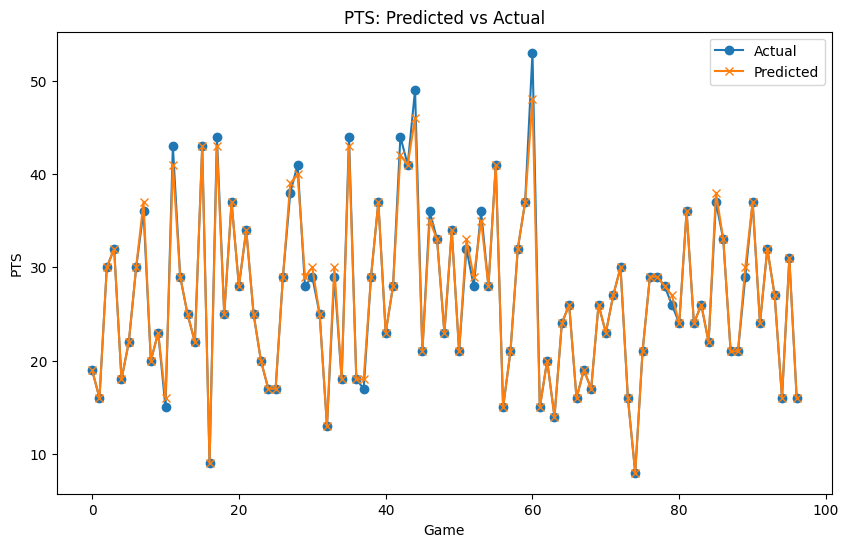

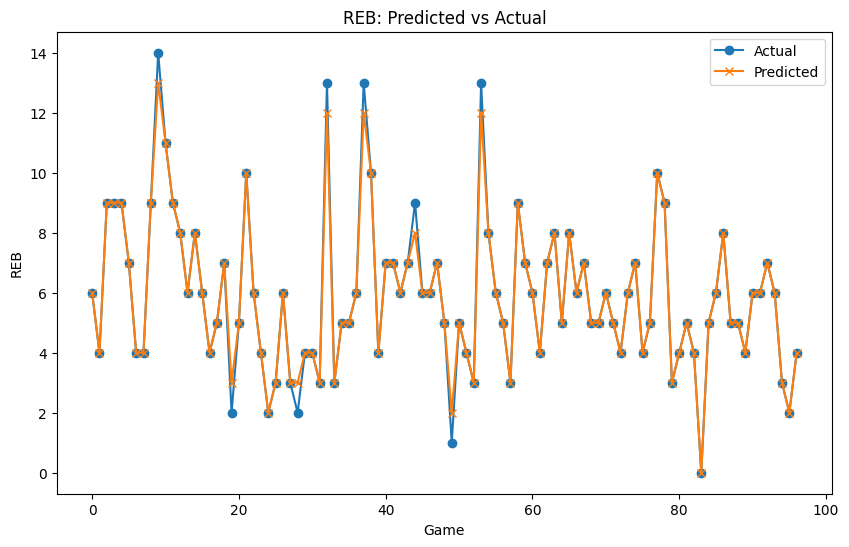

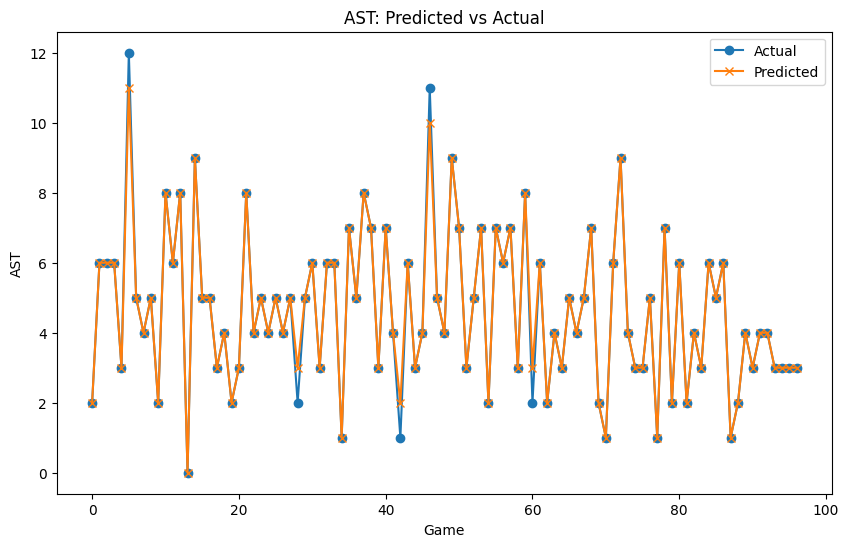

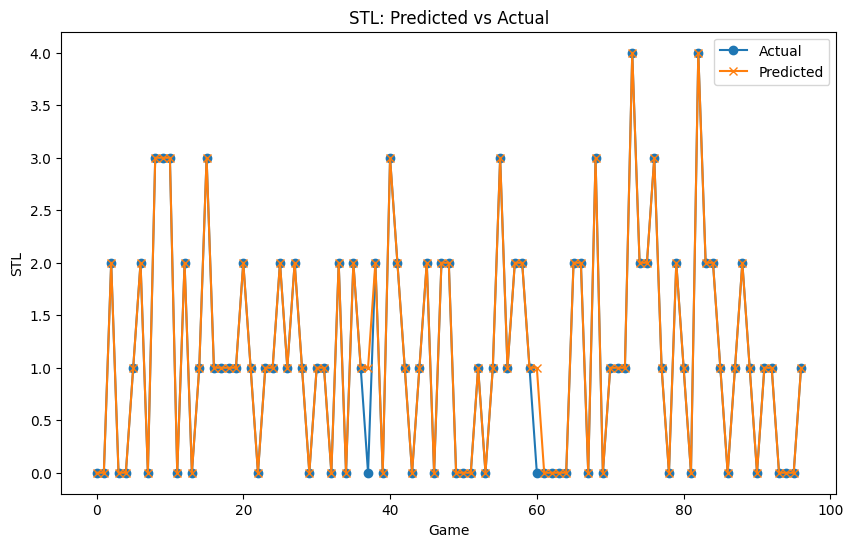

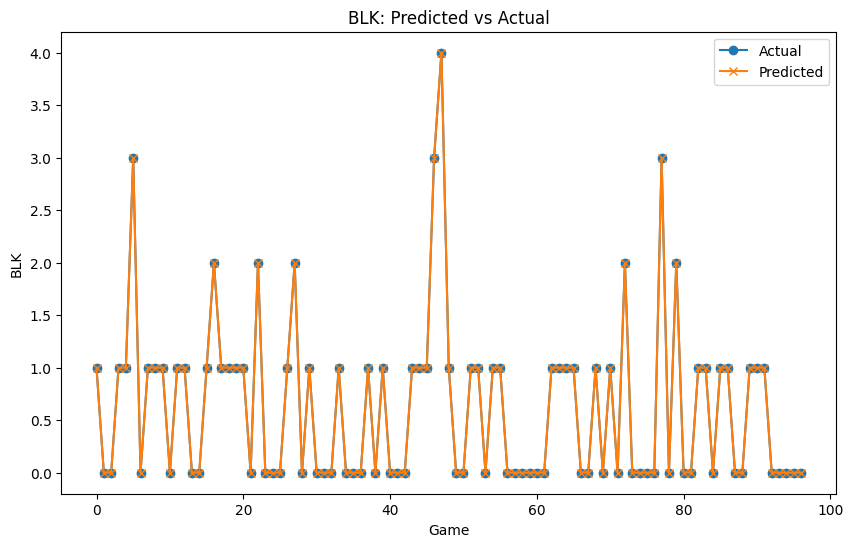

In [12]:
import matplotlib.pyplot as plt

for i, metric in enumerate(['PTS', 'REB', 'AST', 'STL', 'BLK']):
    plt.figure(figsize=(10, 6))
    plt.plot(true_labels[:, i], label='Actual', marker='o')
    plt.plot(np.maximum(np.round(predictions[:, i]), 0), label='Predicted', marker='x')
    plt.title(f'{metric}: Predicted vs Actual')
    plt.xlabel('Game')
    plt.ylabel(metric)
    plt.legend()
    plt.show()



# Predict future game statistics

In [14]:
def json_to_numpy(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    metrics_list = []
    
    for game in data:
        metrics = [
            game['PTS'],
            game['REB'],
            game['AST'],
            game['STL'],
            game['BLK']
        ]
        metrics_list.append(metrics)
    
    metrics_array = np.array(metrics_list)
    
    return metrics_array

historical_data = json_to_numpy(JSONFilePaths[-1])

In [15]:
def predict_next_game(model, historical_data):
    model.eval()
    
    # Calculate average or median of historical data
    avg_metrics = np.mean(historical_data, axis=0)  # Calculate average along rows (axis=0)
    
    # Prepare input tensor
    input_data = torch.tensor(avg_metrics, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_data)
        predictions = outputs.cpu().numpy()
    
    return np.maximum(np.round(predictions.flatten()), 0)

In [16]:
# Example usage:
predicted_metrics = predict_next_game(model, historical_data)
print("Predicted Metrics for Next Game based on Historical Data:", predicted_metrics)

Predicted Metrics for Next Game based on Historical Data: [27.  6.  5.  1.  1.]
